# GeoGuessr Artificial Intelligence Model 🌏🌎🌍

In [204]:
# imports
import numpy as np
import cv2 as cv 
import os
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import folium

## Data Loading 📷

The used dataset is based on Google Streetview captures tagged with the latitude and longitude (geoTagged). The images are organized into folders based on the country they are taken from (the name of the folder is the country code).

This model works with the countries from Europe (from the [UN's point of view](https://www.worldometers.info/geography/how-many-countries-in-europe/)). Excluded Russia as most of its surface is not in Europe

In [129]:
europe_countries_code_list = ["AL", "AD", "AT", "BY", "BE", "BA", "BG", "HR", "CZ", "DK", "EE", "FI", "FR", "DE", "GR", "VA", "HU", "IS", "IE", "IT", "LV", "LI", "LT", "LU", "MT", "MD", "MC", "ME", "NL", "MK", "NO", "PL", "PT", "RO", "SM", "RS", "SK", "SI", "ES", "SE", "CH", "UA", "GB"]

### Data Insights
Let's take a look at the number of images in each folder.

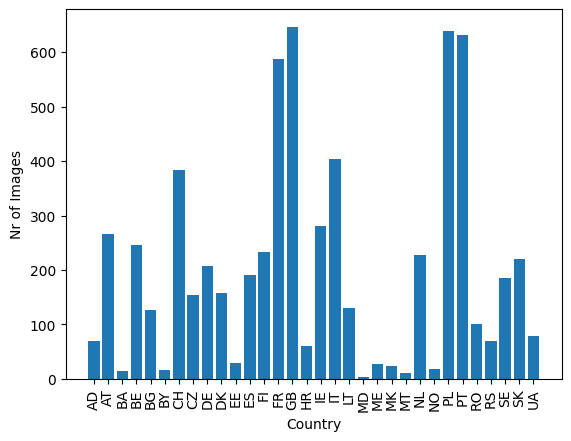

In [134]:
dataset_rel_path = "./data/geotagged_kaggle/streetviews/"
country_nr_images = {}

def count_files_in_dir(dir_path):
    return len(os.listdir(dir_path))

DATASET_ROOT_PATH = os.path.abspath(dataset_rel_path)

for country_folder in os.listdir(DATASET_ROOT_PATH):
    if (country_folder in europe_countries_code_list):
        country_nr_images[country_folder] = len(os.listdir(os.path.join(DATASET_ROOT_PATH, country_folder)))

plt.bar(country_nr_images.keys(), country_nr_images.values())
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Nr of Images")
plt.show()

Let's also plot the report of number of images over the total country surface to observe any imbalances.

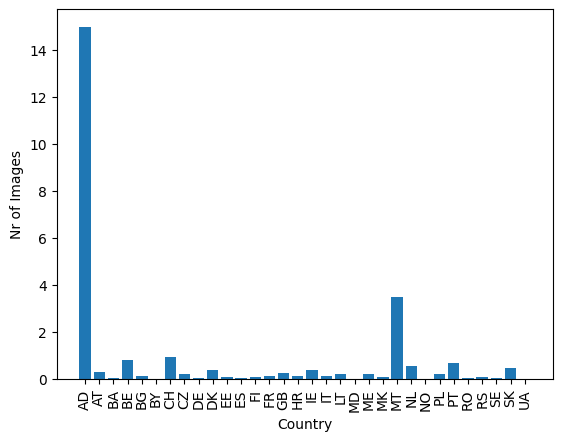

In [143]:
european_country_surface_areas = {
    'AL': 28748,  # Albania
    'AD': 468,    # Andorra
    'AT': 83879,  # Austria
    'BY': 207600, # Belarus
    'BE': 30528,  # Belgium
    'BA': 51197,  # Bosnia and Herzegovina
    'BG': 110879, # Bulgaria
    'HR': 56594,  # Croatia
    'CY': 9251,   # Cyprus
    'CZ': 78865,  # Czech Republic
    'DK': 42924,  # Denmark
    'EE': 45227,  # Estonia
    'FI': 338424, # Finland
    'FR': 551695, # France
    'DE': 357022, # Germany
    'GR': 131957, # Greece
    'HU': 93030,  # Hungary
    'IS': 103000, # Iceland
    'IE': 70273,  # Ireland
    'IT': 301340, # Italy
    'LV': 64589,  # Latvia
    'LI': 160,    # Liechtenstein
    'LT': 65300,  # Lithuania
    'LU': 2586,   # Luxembourg
    'MK': 25713,  # North Macedonia
    'MT': 316,    # Malta
    'MD': 33843,  # Moldova
    'MC': 2,      # Monaco
    'ME': 13812,  # Montenegro
    'NL': 41543,  # Netherlands
    'NO': 1487290,# Norway
    'PL': 312696, # Poland
    'PT': 92212,  # Portugal
    'RO': 238397, # Romania
    'RU': 17098242,# Russia
    'SM': 61,     # San Marino
    'RS': 77474,  # Serbia
    'SK': 49037,  # Slovakia
    'SI': 20273,  # Slovenia
    'ES': 505992, # Spain
    'SE': 450295, # Sweden
    'CH': 41284,  # Switzerland
    'UA': 603500, # Ukraine
    'GB': 243610, # United Kingdom
    'VA': 0.44,   # Vatican City
}

filtered_european_country_surface_areas = {key: european_country_surface_areas[key] for key in country_nr_images.keys()}

for country_code in country_nr_images.keys():
    filtered_european_country_surface_areas[country_code] = country_nr_images[country_code] / filtered_european_country_surface_areas[country_code] * 100

plt.bar(country_nr_images.keys(), filtered_european_country_surface_areas.values())
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Nr of Images")
plt.show()

Let's visualize the geographic distribution of images

In [156]:
str = "a.s.df"
str=str.replace(".", ',')
print(str.split(','))

['a', 's', 'df']


In [182]:
coordinates_data = {
    'path': [],
    'long': [],
    'lat': []
}
for country_folder in os.listdir(DATASET_ROOT_PATH):
    if (country_folder in europe_countries_code_list):
        curr_path = os.path.join(DATASET_ROOT_PATH, country_folder)
        for filename in os.listdir(curr_path):
            curr_lat, curr_long = filename[: -4].split(',')
            coordinates_data['path'].append(os.path.join(curr_path, filename))
            coordinates_data['lat'].append(float(curr_lat))
            coordinates_data['long'].append(float(curr_long))
all_countries_df = pd.DataFrame(coordinates_data)
print(all_countries_df[all_countries_df.lat > 30])

                                                   path      long       lat
0     c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...   1.87154  42.02136
1     c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...   1.88966  42.02381
2     c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...   1.88094  42.02883
3     c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...   1.30027  42.04606
4     c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...   1.84825  42.07719
...                                                 ...       ...       ...
6434  c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...  33.59659  51.83715
6435  c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...  33.49617  51.85592
6436  c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...  33.46536  51.85798
6437  c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...  33.46921  51.86084
6438  c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...  33.47983  51.86134

[6430 rows x 3 columns]


In [221]:
map_center = [45, 15]
my_map = folium.Map(location=map_center, zoom_start=5)


# Add markers for each coordinate
for coordinates in list(zip(all_countries_df.lat, all_countries_df.long)):
    folium.CircleMarker(location=(coordinates[0], coordinates[1]), radius=1).add_to(my_map)

# Save the map as an HTML file
my_map.save("map_with_markers.html")
my_map

### Shuffling and splitting into Test, Validation, and Training sets

Each folder contents will be split into training, validation and test datasets having the percentage 80%, 10%, 10% respectively.